<a href="https://colab.research.google.com/github/iamkeyur/cyclegan-replication/blob/master/NewCycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/iamkeyur/cyclegan-replication

Cloning into 'cyclegan-replication'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 25 (delta 5), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (25/25), done.


In [0]:
import os
os.chdir('cyclegan-replication')
os.mkdir('output')

In [3]:
!bash ./datasets/download.sh horse2zebra

Specified [horse2zebra]
for details.

--2019-12-09 19:32:27--  https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.189.73
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.189.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116867962 (111M) [application/zip]
Saving to: ‘./datasets/horse2zebra.zip’

./datasets/horse2ze 100%[===================>] 111.45M  66.1MB/s    in 1.7s    

2019-12-09 19:32:29 (66.1 MB/s) - ‘./datasets/horse2zebra.zip’ saved [116867962/116867962]

Archive:  ./datasets/horse2zebra.zip
   creating: ./datasets/horse2zebra/trainA/
  inflating: ./datasets/horse2zebra/trainA/n02381460_6223.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_1567.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_3354.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_299.jpg  
  inflating: ./datasets/horse2zebra/tr

In [4]:
!pip install -r requirements.txt

In [5]:
!nvidia-smi

Mon Dec  9 19:32:34 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.36       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import torch
import torch.nn as nn
from torch.nn import init
import functools
from torch.optim import lr_scheduler
import torch.nn.functional as F

In [0]:
class ResnetBlock(nn.Module):
  def __init__(self, dim):
    super(ResnetBlock, self).__init__()
    self.conv = self.build(dim)
  
  def build(self, dim):
    conv = nn.Sequential(
        nn.ReflectionPad2d(1),
        nn.Conv2d(dim, dim, kernel_size=3),
        nn.InstanceNorm2d(dim),
        nn.ReLU(True),
        nn.ReflectionPad2d(1),
        nn.Conv2d(dim, dim, kernel_size=3),
        nn.InstanceNorm2d(dim))
    
    return conv
  
  def forward(self, x):
    return x + self.conv(x)


In [0]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.model = nn.Sequential(
        nn.ReflectionPad2d(3),
        nn.Conv2d(3, 64, kernel_size=7, padding=0),
        nn.InstanceNorm2d(64),
        nn.ReLU(True),

        #downsampling
        nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
        nn.InstanceNorm2d(128),
        nn.ReLU(True),

        nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
        nn.InstanceNorm2d(256),
        nn.ReLU(True),

        #ResnetBlock
        ResnetBlock(256),
        ResnetBlock(256),
        ResnetBlock(256),
        ResnetBlock(256),
        ResnetBlock(256),
        ResnetBlock(256),
        ResnetBlock(256),
        ResnetBlock(256),
        ResnetBlock(256),

        #upsampling
        nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
        nn.InstanceNorm2d(128),
        nn.ReLU(inplace=True),

        nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
        nn.InstanceNorm2d(64),
        nn.ReLU(inplace=True),

        nn.ReflectionPad2d(3),
        nn.Conv2d(64, 3, 7),
        nn.Tanh())
  
  def forward(self, x):
    return self.model(x)

In [0]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.model = nn.Sequential(
        nn.Conv2d(3, 64, 4, stride=2, padding=1),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(64, 128, 4, stride=2, padding=1),
        nn.InstanceNorm2d(128), 
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(128, 256, 4, stride=2, padding=1),
        nn.InstanceNorm2d(256), 
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(256, 512, 4, padding=1),
        nn.InstanceNorm2d(512), 
        nn.LeakyReLU(0.2, inplace=True),

        # FCN classification layer
        nn.Conv2d(512, 1, 4, padding=1))
  
  def forward(self, x):
        x =  self.model(x)
        # Average pooling and flatten
        return F.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1)
        # return x

In [0]:
# netG_A2B = Generator()
# netG_B2A = Generator()
# netD_A = Discriminator()
# netD_B = Discriminator()

In [0]:
# netG_A2B.cuda()
# netG_B2A.cuda()
# netD_A.cuda()
# netD_B.cuda()

In [0]:
def weights_init_normal(model):
  if isinstance(model, nn.Conv2d) or isinstance(model, nn.Linear):
    torch.nn.init.normal(model.weight.data, 0.0, 0.02)


In [0]:
import glob
import random
import os

from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, unaligned=False, mode='train'):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned

        self.files_A = sorted(glob.glob(os.path.join(root, '%s/A' % mode) + '/*.*'))
        self.files_B = sorted(glob.glob(os.path.join(root, '%s/B' % mode) + '/*.*'))

    def __getitem__(self, index):
        item_A = self.transform(Image.open(self.files_A[index % len(self.files_A)]).convert('RGB'))

        if self.unaligned:
            item_B = self.transform(Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)]).convert('RGB'))
        else:
            item_B = self.transform(Image.open(self.files_B[index % len(self.files_B)]).convert('RGB'))

        return {'A': item_A, 'B': item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

In [0]:
import random
import torch

# Borrowed from "Learning from Simulated and Unsupervised Images through Adversarial Training"
# https://raw.githubusercontent.com/junyanz/pytorch-CycleGAN-and-pix2pix/eb6e7dce7940033d84791b87c1a9670e67fa968d/util/image_pool.py

class ImagePool():
    def __init__(self, pool_size=50):
        self.pool_size = pool_size
        if self.pool_size > 0:
            self.num_imgs = 0
            self.images = []

    def push_and_pop(self, images):
        if self.pool_size == 0:
            return images
        return_images = []
        for image in images:
            image = torch.unsqueeze(image.data, 0)
            if self.num_imgs < self.pool_size:
                self.num_imgs = self.num_imgs + 1
                self.images.append(image)
                return_images.append(image)
            else:
                p = random.uniform(0, 1)
                if p > 0.5:
                    random_id = random.randint(0, self.pool_size - 1)
                    tmp = self.images[random_id].clone()
                    self.images[random_id] = image
                    return_images.append(tmp)
                else: 
                    return_images.append(image)
        return_images = torch.cat(return_images, 0)
        return return_images

In [0]:
def tensor2image(tensor):
    image = 127.5*(tensor[0].cpu().float().numpy() + 1.0)
    if image.shape[0] == 1:
        image = np.tile(image, (3,1,1))
    return image.astype(np.uint8)

def Tensor2Image(img):
    """
    input (FloatTensor)
    output (PIL.Image)
    """
    # img = img.cpu()
    # img = img * 0.5 + 0.5
    # img = transforms.ToPILImage()(img)
    img = img[0].cpu().float().numpy()
    R = panda_tensor[0,:,:]
    G = panda_tensor[1,:,:]
    B = panda_tensor[2,:,:]

    img = 0.2989 * R + 0.5870 * G + 0.1140 * B
    return img

In [0]:
class LambdaLR():
    def __init__(self, n_epochs, offset, decay_start_epoch):
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)

In [0]:
import random
import time
import datetime
import sys

from torch.autograd import Variable
import torch
import numpy as np

In [0]:
import argparse
import itertools

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from PIL import Image
import torch
import matplotlib.pyplot as plt

class CycleGAN(object):
  def __init__(self, train=True):
    self.train = train
    self.initialize()
    self.init_weights()

  def initialize(self):
    self.netG_A2B = Generator()
    self.netG_B2A = Generator()
    self.netG_A2B.cuda()
    self.netG_B2A.cuda()

    if self.train:
      self.netD_A = Discriminator()
      self.netD_B = Discriminator()
      self.netD_A.cuda()
      self.netD_B.cuda()
    
    if self.train:
    # Lossess
      self.criterion_GAN = torch.nn.MSELoss()
      self.criterion_cycle = torch.nn.L1Loss()
      self.criterion_identity = torch.nn.L1Loss()

      # Optimizers & LR schedulers
      self.optimizer_G = torch.optim.Adam(itertools.chain(self.netG_A2B.parameters(), self.netG_B2A.parameters()),
                                      lr=0.0002, betas=(0.5, 0.999))
      self.optimizer_D_A = torch.optim.Adam(self.netD_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
      self.optimizer_D_B = torch.optim.Adam(self.netD_B.parameters(), lr=0.0002, betas=(0.5, 0.999))

      self.lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(self.optimizer_G, lr_lambda=LambdaLR(200, 0, 100).step)
      self.lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(self.optimizer_D_A, lr_lambda=LambdaLR(200, 0, 100).step)
      self.lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(self.optimizer_D_B, lr_lambda=LambdaLR(200, 0, 100).step)

      self.fake_A_buffer = ImagePool()
      self.fake_B_buffer = ImagePool()

    # Inputs & targets memory allocation
    Tensor = torch.cuda.FloatTensor
    self.input_A = Tensor(1, 3, 256, 256)
    self.input_B = Tensor(1, 3, 256, 256)
    self.target_real = Variable(Tensor(1).fill_(1.0), requires_grad=False)
    self.target_fake = Variable(Tensor(1).fill_(0.0), requires_grad=False)

  def init_weights(self):
    self.netG_A2B.apply(weights_init_normal)
    self.netG_B2A.apply(weights_init_normal)
    self.netD_A.apply(weights_init_normal)
    self.netD_B.apply(weights_init_normal)

  def set_input(self, data):
    self.real_A = Variable(self.input_A.copy_(data['A']))
    self.real_B = Variable(self.input_B.copy_(data['B']))

  def forward(self, data):
    self.set_input(data)
    self.fake_B = self.netG_A2B(self.real_A)
    self.recovered_A = self.netG_B2A(self.fake_B)
    self.fake_A = self.netG_B2A(self.real_B)
    self.recovered_B = self.netG_A2B(self.fake_A)
  
  def optimize_G_parameters(self):
    self.optimizer_G.zero_grad()
    self.backward_G()
    self.optimizer_G.step()
  
  def optimize_D_parameters(self):
    self.backward_D()
  
  def backward_D(self):
    ###### Discriminator A ######
    self.optimizer_D_A.zero_grad()

    # Real loss
    pred_real = self.netD_A(self.real_A)
    self.loss_D_real = self.criterion_GAN(pred_real, self.target_real)

    # Fake loss
    fake_A = self.fake_A_buffer.push_and_pop(self.fake_A)
    pred_fake = self.netD_A(fake_A.detach())
    self.loss_D_fake = self.criterion_GAN(pred_fake, self.target_fake)

    # Total loss
    self.loss_D_A = (self.loss_D_real + self.loss_D_fake)*0.5
    self.loss_D_A.backward()

    self.optimizer_D_A.step()
    ###################################

    ###### Discriminator B ######
    self.optimizer_D_B.zero_grad()

    # Real loss
    pred_real = self.netD_B(self.real_B)
    self.loss_D_real = self.criterion_GAN(pred_real, self.target_real)
    
    # Fake loss
    fake_B = self.fake_B_buffer.push_and_pop(self.fake_B)
    pred_fake = self.netD_B(fake_B.detach())
    self.loss_D_fake = self.criterion_GAN(pred_fake, self.target_fake)

    # Total loss
    self.loss_D_B = (self.loss_D_real + self.loss_D_fake)*0.5
    self.loss_D_B.backward()

    self.optimizer_D_B.step()

  
  def backward_G(self):
    # Identity loss
    # G_A2B(B) should equal B if real B is fed
    self.same_B = self.netG_A2B(self.real_B)
    self.loss_identity_B = self.criterion_identity(self.same_B, self.real_B)*5.0
    # G_B2A(A) should equal A if real A is fed
    self.same_A = self.netG_B2A(self.real_A)
    self.loss_identity_A = self.criterion_identity(self.same_A, self.real_A)*5.0

    # GAN loss
    pred_fake = self.netD_B(self.fake_B)
    self.loss_GAN_A2B = self.criterion_GAN(pred_fake, self.target_real)

    pred_fake = self.netD_A(self.fake_A)
    self.loss_GAN_B2A = self.criterion_GAN(pred_fake, self.target_real)

    # Cycle loss
    self.loss_cycle_ABA = self.criterion_cycle(self.recovered_A, self.real_A)*10.0

    self.loss_cycle_BAB = self.criterion_cycle(self.recovered_B, self.real_B)*10.0

    # Total loss
    self.loss_G = self.loss_identity_A + self.loss_identity_B + self.loss_GAN_A2B + self.loss_GAN_B2A + self.loss_cycle_ABA + self.loss_cycle_BAB
    self.loss_G.backward()

  def update_lr(self):
    # Update learning rates
    self.lr_scheduler_G.step()
    self.lr_scheduler_D_A.step()
    self.lr_scheduler_D_B.step()

  def save_model(self):
    # Save models checkpoints
    torch.save(self.netG_A2B.state_dict(), 'output/netG_A2B.pth')
    torch.save(self.netG_B2A.state_dict(), 'output/netG_B2A.pth')
    torch.save(self.netD_A.state_dict(), 'output/netD_A.pth')
    torch.save(self.netD_B.state_dict(), 'output/netD_B.pth')
  
  def print(self):
    loss = {'loss_G': self.loss_G, 'loss_G_identity': (self.loss_identity_A + self.loss_identity_B), 'loss_G_GAN': (self.loss_GAN_A2B + self.loss_GAN_B2A),
                    'loss_G_cycle': (self.loss_cycle_ABA + self.loss_cycle_BAB), 'loss_D': (self.loss_D_A + self.loss_D_B)}
    print(loss)

  def show_images(self):
    plt.figure(figsize=(12, 12))

    display_list = [self.real_A, self.fake_B]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
      plt.subplot(1, 2, i+1)
      plt.title(title[i])
      plt.imshow(Tensor2Image(display_list[i]))
      plt.axis('off')
    plt.show()

In [0]:
# import argparse
# import itertools

# import torchvision.transforms as transforms
# from torch.utils.data import DataLoader
# from torch.autograd import Variable
# from PIL import Image
# import torch

# netG_A2B.apply(random_weights)
# netG_B2A.apply(random_weights)
# netD_A.apply(random_weights)
# netD_B.apply(random_weights)

# # Lossess
# criterion_GAN = torch.nn.MSELoss()
# criterion_cycle = torch.nn.L1Loss()
# criterion_identity = torch.nn.L1Loss()

# # Optimizers & LR schedulers
# optimizer_G = torch.optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()),
#                                 lr=0.0002, betas=(0.5, 0.999))
# optimizer_D_A = torch.optim.Adam(netD_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
# optimizer_D_B = torch.optim.Adam(netD_B.parameters(), lr=0.0002, betas=(0.5, 0.999))

# lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(200, 0, 100).step)
# lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=LambdaLR(200, 0, 100).step)
# lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=LambdaLR(200, 0, 100).step)

# # Inputs & targets memory allocation
# Tensor = torch.cuda.FloatTensor
# input_A = Tensor(1, 3, 256, 256)
# input_B = Tensor(1, 3, 256, 256)
# target_real = Variable(Tensor(1).fill_(1.0), requires_grad=False)
# target_fake = Variable(Tensor(1).fill_(0.0), requires_grad=False)

# fake_A_buffer = ImagePool()
# fake_B_buffer = ImagePool()

# Dataset loader
transforms_ = [ transforms.Resize(286, Image.BICUBIC), 
                transforms.RandomCrop(256), 
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) ]
dataloader = DataLoader(ImageDataset("datasets/horse2zebra/", transforms_=transforms_, unaligned=True), 
batch_size=1, shuffle=True, num_workers=8)

In [0]:
# ###### Training ######
# for epoch in range(0, 200):
#     print(epoch)
#     for i, batch in enumerate(dataloader):
#         # Set model inpu
#         real_A = Variable(input_A.copy_(batch['A']))
#         real_B = Variable(input_B.copy_(batch['B']))
        

#         ###### Generators A2B and B2A ######
#         optimizer_G.zero_grad()

#         # Identity loss
#         # G_A2B(B) should equal B if real B is fed
#         same_B = netG_A2B(real_B)
#         loss_identity_B = criterion_identity(same_B, real_B)*5.0
#         # G_B2A(A) should equal A if real A is fed
#         same_A = netG_B2A(real_A)
#         loss_identity_A = criterion_identity(same_A, real_A)*5.0

#         # GAN loss
#         fake_B = netG_A2B(real_A)
#         pred_fake = netD_B(fake_B)
#         loss_GAN_A2B = criterion_GAN(pred_fake, target_real)

#         fake_A = netG_B2A(real_B)
#         pred_fake = netD_A(fake_A)
#         loss_GAN_B2A = criterion_GAN(pred_fake, target_real)

#         # Cycle loss
#         recovered_A = netG_B2A(fake_B)
#         loss_cycle_ABA = criterion_cycle(recovered_A, real_A)*10.0

#         recovered_B = netG_A2B(fake_A)
#         loss_cycle_BAB = criterion_cycle(recovered_B, real_B)*10.0

#         # Total loss
#         loss_G = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB
#         loss_G.backward()
        
#         optimizer_G.step()
#         ###################################

#         ###### Discriminator A ######
#         optimizer_D_A.zero_grad()

#         # Real loss
#         pred_real = netD_A(real_A)
#         loss_D_real = criterion_GAN(pred_real, target_real)

#         # Fake loss
#         fake_A = fake_A_buffer.push_and_pop(fake_A)
#         pred_fake = netD_A(fake_A.detach())
#         loss_D_fake = criterion_GAN(pred_fake, target_fake)

#         # Total loss
#         loss_D_A = (loss_D_real + loss_D_fake)*0.5
#         loss_D_A.backward()

#         optimizer_D_A.step()
#         ###################################

#         ###### Discriminator B ######
#         optimizer_D_B.zero_grad()

#         # Real loss
#         pred_real = netD_B(real_B)
#         loss_D_real = criterion_GAN(pred_real, target_real)
        
#         # Fake loss
#         fake_B = fake_B_buffer.push_and_pop(fake_B)
#         pred_fake = netD_B(fake_B.detach())
#         loss_D_fake = criterion_GAN(pred_fake, target_fake)

#         # Total loss
#         loss_D_B = (loss_D_real + loss_D_fake)*0.5
#         loss_D_B.backward()

#         optimizer_D_B.step()
#         ###################################

#         # # Progress report (http://localhost:8097)
#         # logger.log({'loss_G': loss_G, 'loss_G_identity': (loss_identity_A + loss_identity_B), 'loss_G_GAN': (loss_GAN_A2B + loss_GAN_B2A),
#         #             'loss_G_cycle': (loss_cycle_ABA + loss_cycle_BAB), 'loss_D': (loss_D_A + loss_D_B)}, 
#         #             images={'real_A': real_A, 'real_B': real_B, 'fake_A': fake_A, 'fake_B': fake_B})
        
#     plt.figure(figsize=(12, 12))

#     display_list = [real_A, fake_B]
#     title = ['Input Image', 'Predicted Image']

#     for i in range(2):
#       plt.subplot(1, 2, i+1)
#       plt.title(title[i])
#       plt.imshow(Tensor2Image(display_list[i]))
#       plt.axis('off')
#     plt.show()


#     # Update learning rates
#     lr_scheduler_G.step()
#     lr_scheduler_D_A.step()
#     lr_scheduler_D_B.step()

#     # Save models checkpoints
#     torch.save(netG_A2B.state_dict(), 'output/netG_A2B.pth')
#     torch.save(netG_B2A.state_dict(), 'output/netG_B2A.pth')
#     torch.save(netD_A.state_dict(), 'output/netD_A.pth')
#     torch.save(netD_B.state_dict(), 'output/netD_B.pth')
# ###################################

Mon Dec  9 19:35:40 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.36       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    32W / 250W |   4647MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


{'loss_G': tensor(6.8813, device='cuda:0', grad_fn=<AddBackward0>), 'loss_G_identity': tensor(1.9130, device='cuda:0', grad_fn=<AddBackward0>), 'loss_G_GAN': tensor(1.2783, device='cuda:0', grad_fn=<AddBackward0>), 'loss_G_cycle': tensor(3.6900, device='cuda:0', grad_fn=<AddBackward0>), 'loss_D': tensor(0.6263, device='cuda:0', grad_fn=<AddBackward0>)}


ValueError: ignored

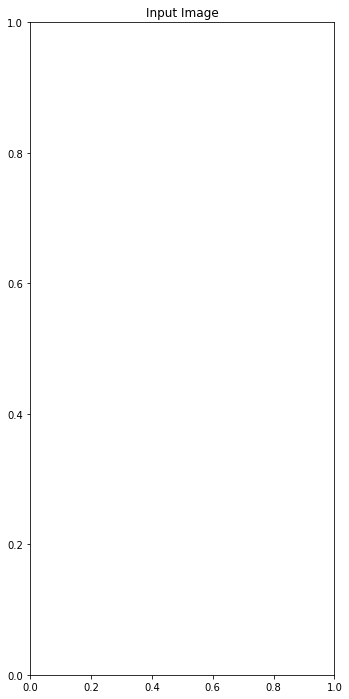

In [32]:
!nvidia-smi
model = CycleGAN()
for epoch in range(0, 200):
    print(epoch)
    for i, batch in enumerate(dataloader):
        model.forward(batch)
        model.optimize_G_parameters()
        model.optimize_D_parameters()
    model.print()    
    model.show_images()


    model.update_lr()
    model.save()
###################################